In [1]:
from __future__ import print_function
import os
import os.path
import numpy as np
from dataIO import pk
import torch.utils.data as data
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from time import time
from PIL import Image

In [2]:
class Feline(data.Dataset):
    filename_train = "train.gz"
    filename_validation = "validation.gz"
    filename_test = "test.gz"
    
    def targets(self):
        if self.train:
            return self.train_labels
        else:
            return self.test_labels
    
    def __init__(self, root, train=True, test=True,
                 transform=None, target_transform=None, blur = None):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.test = test

        # now load the picked numpy arrays
        if self.train:
            self.train_data = []
            self.train_labels = []
            file = os.path.join(self.root, self.filename_train)
            entry = pk.load(file)
            self.train_data.append(entry['data'])
            self.train_labels = entry['label']

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((-1, 32, 32, 3))
            
            
        elif self.test:
            file = os.path.join(self.root, self.filename_test)
            entry = pk.load(file)
            self.test_data = entry["data"]
            self.test_labels = entry['label']
            self.test_data = self.test_data.reshape((-1, 32, 32, 3))
        
        else:
            file = os.path.join(self.root, self.filename_validation)
            entry = pk.load(file)
            self.validation_data = entry["data"]
            self.validation_labels = entry['label']
            self.validation_data = self.validation_data.reshape((-1, 32, 32, 3))
                
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        elif self.test:
            img, target = self.test_data[index], self.test_labels[index]
        else:
            img, target = self.validation_data[index], self.validation_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        elif self.test:
            return len(self.test_data)
        else:
            return len(self.validation_data)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [3]:
rootpath = '.'

Transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])


train = Feline(rootpath, train=True, test = False,\
                       transform=Transform)#transforms.ToTensor())
validation = Feline(rootpath, train=False, test = False, \
                       transform=Transform)#transforms.ToTensor())
test = Feline(rootpath, train=False, test = True, \
                       transform=Transform)#transforms.ToTensor())


Load from './train.gz' ...
    Complete! Elapse 0.090813 sec.

Load from './validation.gz' ...
    Complete! Elapse 1.125439 sec.

Load from './test.gz' ...
    Complete! Elapse 0.011259 sec.


In [4]:



train_loader = torch.utils.data.DataLoader(train,\
                                           batch_size=32,\
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation,\
                                           batch_size=32,\
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test,\
                                          batch_size=32,\
                                          shuffle=True)

In [5]:
class net(nn.Module):

    def __init__(self, num_classes=4):
        super(net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [6]:
model = net()
# for param in list(model.parameters())[:-2]:
#     param.requires_grad = False     
if torch.cuda.is_available():
    model.cuda()
print(model)

net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_features=40

In [7]:
def sampleAccuracyandLoss(dataloader, net):
    correct = 0
    total = 0
    running_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data       
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)       
        running_loss += loss.cpu().data[0]
        
        _, predicted = torch.max(outputs.data, 1)        
        total += labels.size(0)
        labels = labels.view(labels.size()[0])
        correct += (predicted == labels.data).sum()
    res = running_loss/len(dataloader)
    return correct.cpu().data.numpy() / total, res


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr = 0.001, weight_decay=0.0005)
acc_test =[] 
loss_train, loss_test = [],[]

for epoch in range(50):  # loop over the dataset multiple times
    loss_acum = 0
 
    for i, data in enumerate(train_loader, 0):        
        inputs, labels = data       
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())        
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss_acum += float(loss.data.cpu().numpy())
        loss.backward()
        optimizer.step() 
        
    loss_train.append(loss_acum/len(train_loader))    
    at, lt = sampleAccuracyandLoss(test_loader, model)
    acc_test.append(at)
    loss_test.append(lt)
    print("Test accuracy : %s" % at)
    print("Test loss : %s" % lt)
    print("Train loss :", loss_acum/len(train_loader))
    print("Finishing epoch : %s" % epoch)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()


Test accuracy : 0.568
Test loss : tensor(1.1518)
Train loss : 1.187829955688958
Finishing epoch : 0
Test accuracy : 0.322
Test loss : tensor(1.3167)
Train loss : 1.1042361004838666
Finishing epoch : 1
Test accuracy : 0.562
Test loss : tensor(1.0763)
Train loss : 1.0470072673362436
Finishing epoch : 2
Test accuracy : 0.588
Test loss : tensor(1.0251)
Train loss : 0.9892014901614884
Finishing epoch : 3
Test accuracy : 0.554
Test loss : tensor(1.0720)
Train loss : 0.918150588725377
Finishing epoch : 4
Test accuracy : 0.542
Test loss : tensor(1.0700)
Train loss : 0.8877605118797821
Finishing epoch : 5
Test accuracy : 0.546
Test loss : tensor(1.0925)
Train loss : 0.8572629128844993
Finishing epoch : 6
Test accuracy : 0.424
Test loss : tensor(1.3993)
Train loss : 0.810017380899596
Finishing epoch : 7
Test accuracy : 0.614
Test loss : tensor(1.1300)
Train loss : 0.7759433492873479
Finishing epoch : 8
Test accuracy : 0.624
Test loss : tensor(0.9950)
Train loss : 0.7523775424772096
Finishing epo

KeyboardInterrupt: 

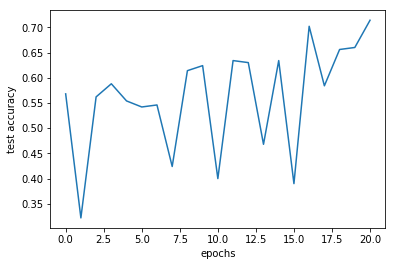

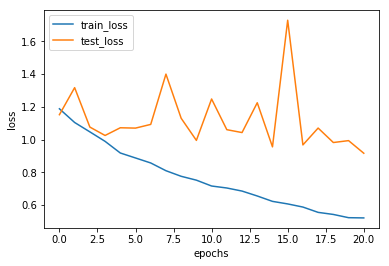

In [10]:
import matplotlib.pyplot as plt
plt.plot(acc_test)
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.show()
plt.plot(loss_train)
plt.plot(loss_test)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])
plt.show()